In [7]:
import math

import numpy as np


def smart_histogram(v, categorical=False, trim=0.025):
    """
    Create histogram h,x from array v with "smart" binning:
      - If categorical=True, treat v as categorical and remove categories with <2.5% freq.
      - If not categorical:
          - Remove top and bottom 2.5% (or `trim` fraction) of values.
          - Determine if all values are effectively integers.
          - Use Freedman-Diaconis rule for bin width, then round to a nice number.
    Returns:
      h: histogram counts
      x: bin edges (for numeric) or unique categories (for categorical)
    """
    v = np.asarray(v)
    if len(v) == 0:
        return np.array([]), np.array([])

    if categorical:
        # Categorical handling
        cats, counts = np.unique(v, return_counts=True)
        total = len(v)
        freq = counts / total

        # Filter out rare categories
        mask = freq >= trim
        cats = cats[mask]

        # Filter data to these categories only
        v_filtered = v[np.isin(v, cats)]

        # Return counts by category. For categorical, x are just the categories
        # Keep categories sorted by their natural order
        cats_sorted = np.sort(cats)
        h = np.array([np.sum(v_filtered == c) for c in cats_sorted])
        return h, cats_sorted
    else:
        # Non-categorical (continuous or ordinal)
        # Trim extremes
        if trim > 0:
            lower_bound = np.percentile(v, 100 * trim)
            upper_bound = np.percentile(v, 100 * (1 - trim))
            v_filtered = v[(v >= lower_bound) & (v <= upper_bound)]
        else:
            v_filtered = v

        if len(v_filtered) == 0:
            return np.array([]), np.array([])

        # Check if effectively integral
        is_integral = np.allclose(v_filtered, v_filtered.astype(int))

        # Freedman-Diaconis bin width
        q1, q3 = np.percentile(v_filtered, [25, 75])
        iqr = q3 - q1
        if iqr > 0:
            bin_width = 2 * iqr * (len(v_filtered) ** (-1/3))
        else:
            # If IQR=0, fallback to a default
            data_range = v_filtered.max() - v_filtered.min()
            bin_width = data_range / 10 if data_range != 0 else 1

        if bin_width <= 0:
            # If still <=0, fallback
            data_range = v_filtered.max() - v_filtered.min()
            bin_width = data_range / 10 if data_range != 0 else 1

        # Function to choose a nice number for bin width
        def nice_number(x):
            if x <= 0:
                return 1.0
            exp = math.floor(math.log10(x))
            frac = x / (10**exp)
            if frac < 1.5:
                nice_frac = 1
            elif frac < 3:
                nice_frac = 2
            elif frac < 7:
                nice_frac = 5
            else:
                nice_frac = 10
            return nice_frac * 10**exp

        nice_bin_width = nice_number(bin_width)

        if is_integral:
            nice_bin_width = max(1, round(nice_bin_width))

        data_min = v_filtered.min()
        data_max = v_filtered.max()

        # Align start to a nice boundary
        start = math.floor(data_min / nice_bin_width) * nice_bin_width
        while start > data_min:
            start -= nice_bin_width

        # Calculate number of bins needed
        n_bins = math.ceil((data_max - start) / nice_bin_width)
        end = start + n_bins * nice_bin_width

        # If integral, ensure the bin boundaries are integers
        if is_integral:
            start = int(math.floor(start))
            end = int(math.ceil(end))
            # Adjust n_bins based on integral width
            n_bins = (end - start) // nice_bin_width
            if (end - start) % nice_bin_width != 0:
                n_bins = int(math.ceil((end - start) / nice_bin_width))

        bins = start + np.arange(n_bins + 1) * nice_bin_width

        if is_integral:
            bins = bins.astype(int)

        h, x = np.histogram(v_filtered, bins=bins)
        return h, x

# Example usage:
v = np.random.randint(0, 10,1000) # continuous
h, x = smart_histogram(v, categorical=True)


In [6]:
v

617

<Axes: >

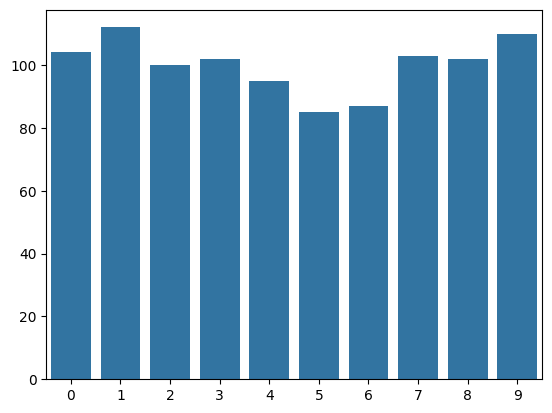

In [9]:
import seaborn as sns

sns.barplot(x=x,y=h)